In [1]:
import chess
import chess.pgn
import math 
import network
import tensorflow as tf
import games_parser as gp
import itertools as it
import numpy as np
import tfdeploy as td
import time
from IPython.display import SVG, display

In [2]:
mode = td.Model("model.pkl")
x1, x2, y = mode.get("position_one", "position_two", "answer")

def eval_func(pos1, pos2): 
    r = y.eval({x1:pos1, x2:pos2})
    return r

In [3]:
# def eval_func(pos1, pos2): 
#     with tf.Graph().as_default() as g:
#         with tf.Session(config=tf.ConfigProto( allow_soft_placement=True,log_device_placement=True)) as sess:
#             x1_ = tf.placeholder(tf.float32, shape=[1,773], name="position_one")
#             x2_ = tf.placeholder(tf.float32, shape=[1,773], name="position_two")
#             result = network.supervised_model(x1_, x2_)
#             ans = tf.nn.softmax(result, name = "answer")
#             all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
#             auto_weights = []
#             for scope_name in ['encode1', 'encode2', 'encode3', 'encode4'] :
#                 auto_weights.append(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope= scope_name) )


#                 model_path= "./tmp2/feed_forward.ckpt"
#                 for level, ae_vars in enumerate(auto_weights):
#                     ae_saver = tf.train.Saver( ae_vars  )
#                     ae_saver.restore(sess, './tmp2/encoder_ae{}.ckpt'.format(level+1) )

#                 saver = tf.train.Saver(all_vars)
#                 saver.restore(sess, model_path)  

#                 return(sess.run( ans, feed_dict={x1_: pos1, x2_: pos2} ))


In [4]:
def get_bit( board ):
    '''
    Input :
        board = copy of the board on which the game is played
        move = "e2e4" style 
    '''
    # FEN represntation of the board
    position = board.board_fen() 
    # A board representing the position of chess pieces.
    baseboard = chess.BaseBoard(position) 
    bit_b = gp.bit_board_gen(board, baseboard, "0")
    bit_b.pop()
    return np.array([bit_b])
    

In [5]:
def better( move1, move2 ):
    index = np.argmax( eval_func(get_bit(move1), get_bit(move2) )[0] ) 
    return (move1, move2)[index]

def worse( move1, move2 ):
    index = np.argmin( eval_func(get_bit(move1), get_bit(move2) )[0] ) 
    return (move1, move2)[index]

In [6]:
def argmaxi(state, function):
    
    def pusher(board, move):
        b = board.copy()
        b.push(move)
        return b

    seq = list( map( lambda move: pusher(state, move) , state.legal_moves  ) ) 
    
    best_move, best_score = seq[0], function(seq[0])

    for node in (seq):
        value = function(node)
        if better(best_move, node) == node :
            best_move, best_score = node, value
            
    return best_move

In [22]:
def alphabeta_search(state, d=5, cutoff_test=None):
    """Search game to determine best action; use alpha-beta pruning.
    This version cuts off search and uses an evaluation function."""

    def max_value(state, alpha, beta, depth):
        if cutoff_test(state, depth):
            return state
        v = -math.inf
        for mv in state.legal_moves:
            s = state.copy()
            s.push(mv)
            
            if v == -math.inf:
                v = min_value(s,alpha,beta,depth+1)
            if beta ==  math.inf:   
                beta = v
                
            v = better(v, min_value(s, alpha, beta, depth+1))
            if beta != math.inf:
                if better(v, beta) == v :
                    return v
            alpha = better(alpha, v)
        return v

    def min_value(state, alpha, beta, depth):
        if cutoff_test(state, depth):
            return state
        v = math.inf
        for mv in state.legal_moves:
            s = state.copy()
            s.push(mv)
            
            if v == math.inf:
                v = max_value(s,alpha,beta,depth+1)
            if alpha == -math.inf:
                alpha = v
                
            v = worse(v, max_value(s, alpha, beta, depth+1))
            if alpha != -math.inf:
                if worse(v, alpha) == v :
                    return v
            beta = worse(beta, v)
        return v
   
    cutoff_test = (cutoff_test or
                   (lambda state,depth: depth>d or state.is_game_over()))
    
    action  = argmaxi(state, lambda board : min_value(board, -math.inf, math.inf, 0))
    return action

In [8]:
def anthony_joshua(state):
    return alphabeta_search(state)


In [9]:
# m = chess.Board('rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 1') 
# v = chess.Board('rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 0 1')

In [10]:
def users_move(board):
    while True:
        try:
            move = input("Enter your move in ''Nb1a3'' style \n")
            board.push_san(move)
            break
        except ValueError:
            print("Ambiguous Move..")
    return board

In [16]:
def playgame():
    moveTotal = 0;
    board = chess.Board()
    while board.is_game_over() == False:
        if moveTotal % 2 == 1:
            board = users_move(board)
        else:
            st = time.time()
            board = anthony_joshua(board)
            print("MoveTime:", time.time() -st)
        print(display(board))
        moveTotal = moveTotal+1
    print("Game-over")

In [ ]:
m1 = chess.Board('rqb2rk1/3nbppQ/p2pp3/4P1P1/1p1B1P2/2NB4/PPP4P/2KR3R w Kq - 0 1')
m2 = chess.Board('Qqb2rk1/3nbpp1/p2pp3/4P1P1/1p1B1P2/2NB4/PPP4P/2KR3R w Kq - 0 10')

C:\Users\User\Anaconda3\lib\site-packages\tfdeploy.py:2081: RuntimeWarning: overflow encountered in exp
  e = np.exp(a)
C:\Users\User\Anaconda3\lib\site-packages\tfdeploy.py:2082: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(e, np.sum(e, axis=-1, keepdims=True)),


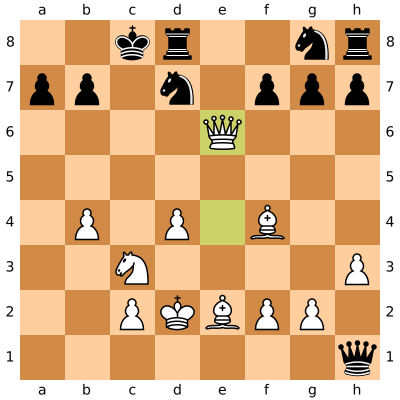

In [59]:
m = chess.Board('2kr2nr/pp1n1ppp/4p3/8/1P1PQB2/2N4P/2PKBPP1/7q w KQkq - 0 10')
anthony_joshua(m)